In [1]:
# import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# BigQuery settings
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
import google.auth

credentials, your_project_id = google.auth.default( scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient = bigquery.Client(credentials=credentials, project="som-nero-phi-jonc101",)



In [2]:
df_list=[]

### Unique Workstations
  
 

In [3]:
query = '''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "% lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),


AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    COUNT(DISTINCT workstation_id) AS num_unq_wrkstn
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
)

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    AVG(num_unq_wrkstn) AS num_unq_wrkstn
FROM 
    ALL_TT_METRICS
GROUP BY 
    1,2,3 
    ORDER BY 
    tpa_admin_time
'''



In [4]:
dataframe = bqclient.query(query).result().to_dataframe()
print(dataframe)
dataframe= dataframe[['pat_enc_csn_id_coded', 'num_unq_wrkstn']]
print(dataframe.head())
df_list.append(dataframe)

     pat_enc_csn_id_coded      tpa_admin_time emergency_admit_time  \
0            131011501539 2010-11-17 13:19:00  2010-11-17 12:18:00   
1            131011574201 2010-11-23 22:39:00  2010-11-23 21:45:00   
2            131012179111 2011-01-23 12:18:00  2011-01-23 10:31:00   
3            131012404716 2011-02-10 13:05:00  2011-02-10 12:05:00   
4            131012428441 2011-02-13 11:08:00  2011-02-13 09:43:00   
..                    ...                 ...                  ...   
223          131223517964 2017-03-27 18:36:00  2017-03-27 18:06:00   
224          131224318222 2017-04-03 17:50:00  2017-04-03 16:39:00   
225          131225347064 2017-04-12 21:35:00  2017-04-12 21:03:00   
226          131226142346 2017-04-20 13:09:00  2017-04-20 12:55:00   
227          131229540038 2017-05-12 16:19:00  2017-05-12 15:38:00   

     num_unq_wrkstn  
0          1.950000  
1          2.294118  
2          1.714286  
3          1.840000  
4          2.083333  
..              ...  
223  

### Task Switching

In [5]:
query = '''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT
AL.rit_uid,
AL.pat_enc_csn_id_coded,
min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time,
min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,
FROM `noshad.cohort_AL_60` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.rit_uid, AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),
PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
FROM `noshad.cohort_AL_60` as AL
WHERE
(metric_name like "%Lab%" OR metric_name like "% lab%"
OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
OR metric_name like "%Order%" OR metric_name like "%order%"
OR metric_name like "%Result%" OR metric_name like "%result%"
OR metric_name like "%Medications%" OR metric_name like "%medications%"
OR metric_name like "%MAR%"
OR metric_name like "%Note%" OR metric_name like "%note%"
OR metric_name like "%History%" OR metric_name like "%history%"
OR metric_name like "%Imag%" OR metric_name like "%imag%"
)
GROUP BY pat_enc_csn_id_coded, user_deid, emergencyAdmitTime, tpaOrderTime
),
TT AS
(
SELECT
*
FROM
TPAP_ACTUAL_TIMES
INNER JOIN
PROVIDER_MAPPING
USING
(pat_enc_csn_id_coded)
),
-- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE
AL.rit_uid=TMP.ANON_ID
AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),
FILTERED_EVENTS AS (
SELECT
TT.*,
AL_ALL_ACTUAL_TIMES.access_time_real,
AL_ALL_ACTUAL_TIMES.metric_name,
AL_ALL_ACTUAL_TIMES.workstation_id,
AL_ALL_ACTUAL_TIMES.rit_uid AS patient_id,
LEAD(AL_ALL_ACTUAL_TIMES.rit_uid)
OVER (PARTITION BY pat_enc_csn_id_coded, provider_id ORDER BY access_time_real ASC) AS next_patient_id
FROM
TT
INNER JOIN
AL_ALL_ACTUAL_TIMES
ON
AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id
WHERE
access_time_real BETWEEN tw_start_time AND tw_end_time
ORDER BY
pat_enc_csn_id_coded, provider_id, access_time_real
),
TASK_SWITCHING AS
(
SELECT
*,
(CASE WHEN patient_id = next_patient_id THEN 0 ELSE 1 END) AS task_switched
FROM FILTERED_EVENTS
),
PROVIDER_LEVEL_SWITCHING AS
(
SELECT
DATETIME_DIFF(tpa_admin_time, emergency_admit_time, MINUTE) AS tpa_min,
pat_enc_csn_id_coded,
provider_id,
SUM(task_switched) AS total_switching,
COUNT(distinct(patient_id))-1 AS view_count
FROM TASK_SWITCHING
GROUP BY 1, pat_enc_csn_id_coded, provider_id
)

SELECT 
    pat_enc_csn_id_coded,
    tpa_min,
    AVG(total_switching) AS avg_task_switching,
    AVG(view_count) AS view_count
FROM 
    PROVIDER_LEVEL_SWITCHING
GROUP BY 
    1,2
'''

Update April 15th, 2022: 'View count' removed from the dataframe that we are adding to DF list

In [6]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'tpa_min', 'avg_task_switching']]
print(dataframe.head())
df_list.append(dataframe)

   pat_enc_csn_id_coded  tpa_min  avg_task_switching
0          131030165916       46           24.263158
1          131126720463        8           33.136364
2          131165619949       42           17.444444
3          131181062815       67           60.200000
4          131182886510       20           36.913043


In [7]:
print(dataframe)

     pat_enc_csn_id_coded  tpa_min  avg_task_switching
0            131030165916       46           24.263158
1            131126720463        8           33.136364
2            131165619949       42           17.444444
3            131181062815       67           60.200000
4            131182886510       20           36.913043
..                    ...      ...                 ...
223          131028333891       63           56.437500
224          131042907349       36           11.045455
225          131018109610       62           26.090909
226          131013143536       50           20.944444
227          131021984186       69           14.307692

[228 rows x 3 columns]


### Chart views
Robert Edits: Changing this so that we are measuring the number of distinct views of other patients, not the total number of views of other patient's "%encounter%" metrics.
As of January 14th - Trying to determine why there are 252 unique CSN's in one table versus 243 in another.
Update: April 15th, 236 chart views versus 228 actual patients.
Robert searched the code and found this table had a unique event "reports" which was added to the definiton to find providers. Deleted that line.

In [8]:
query='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.rit_uid,
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,
FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.rit_uid, AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),
PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    (metric_name like "%Lab%" OR metric_name like "% lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"    
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"
    )
  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),
TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),
  -- Generate AL with actual times where metric name is Encounter%. 
  -- Every chart view should have at least one Encounter metric name.
  -- For the MOORE work, we do not want this restriction. Removing it.
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE 
    AL.rit_uid=TMP.ANON_ID
ORDER BY AL.rit_uid
),
FILTERED_EVENTS AS (
SELECT 
  TT.*, 
  TT.rit_uid AS INDEX_UID,
  AL_ALL_ACTUAL_TIMES.access_time_real, 
  AL_ALL_ACTUAL_TIMES.metric_name, 
  AL_ALL_ACTUAL_TIMES.workstation_id,
  AL_ALL_ACTUAL_TIMES.rit_uid AS other_uid  
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
    AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id
WHERE
  access_time_real BETWEEN tw_start_time AND tw_end_time
ORDER BY 
    pat_enc_csn_id_coded, provider_id, access_time_real
),
-- Subtract 1 from the counts since we don't want to include the index patient.
PROVIDER_LEVEL_METRIC AS
(
SELECT 
    -- DATETIME_DIFF(tpa_admin_time, emergency_admit_time, MINUTE) AS tpa_min,
    pat_enc_csn_id_coded, 
    provider_id, 
    COUNT(DISTINCT(other_uid)) - 1 AS view_count 
    FROM FILTERED_EVENTS
GROUP BY pat_enc_csn_id_coded, provider_id
)

SELECT pat_enc_csn_id_coded, AVG(view_count) AS view_count
FROM PROVIDER_LEVEL_METRIC
GROUP BY 1

'''


In [9]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe= dataframe[['pat_enc_csn_id_coded', 'view_count']]
print(dataframe)
df_list.append(dataframe)

     pat_enc_csn_id_coded  view_count
0            131054000333   20.894737
1            131016436691   63.037037
2            131022440550   30.647059
3            131086918819   11.450000
4            131199746351    7.468750
..                    ...         ...
223          131015332320   66.000000
224          131189048329   13.954545
225          131017369131   58.607143
226          131020001641   58.470588
227          131028333891   12.812500

[228 rows x 2 columns]


In [10]:
#bad_df[bad_df.pat_enc_csn_id_coded.isin(dataframe.pat_enc_csn_id_coded) == False]

### Days Since Last TPA Case

In [11]:
query='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "% lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    DATETIME_DIFF(tpa_admin_time, LAG(emergency_admit_time) -- ,1,DATETIME(2000,1,1,0,0,0)
    OVER (PARTITION BY provider_id ORDER BY emergency_admit_time ASC), DAY) AS day_since_last_tpa
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4
ORDER BY emergency_admit_time
),

-- Changing this so that the default for missing values is not 30, but is null.
ALL_TT_METRICS_2 AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    (CASE WHEN day_since_last_tpa IS NOT NULL THEN day_since_last_tpa ELSE NULL END) AS day_since_last_tpa
FROM 
    ALL_TT_METRICS
),
-- REMOVE ANY ENCOUNTERS WITHIN THE 1st 30 days of the study period so that we have a bit of a washout period to
-- accumlate strokes cases for providers.
FIND_EARLIEST_ENC AS (
SELECT 
    DATETIME_ADD(MIN(tpa_admin_time), INTERVAL 30 DAY) as CUTOFF_DATE FROM ALL_TT_METRICS_2
),
EARLIEST_TO_DELETE AS (
SELECT
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    provider_id,
    case when tpa_admin_time >= CUTOFF_DATE then day_since_last_tpa else NULL end AS day_since_last_tpa
FROM
    ALL_TT_METRICS_2, FIND_EARLIEST_ENC
),
FINAL AS(
SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    MIN(day_since_last_tpa) AS day_since_last_tpa
FROM 
    EARLIEST_TO_DELETE
GROUP BY 
    1,2,3
)

SELECT * FROM FINAL
'''

In [12]:
dataframe = bqclient.query(query).result().to_dataframe()
dataframe = dataframe[['pat_enc_csn_id_coded', 'day_since_last_tpa']]
print(dataframe)
df_list.append(dataframe)

     pat_enc_csn_id_coded  day_since_last_tpa
0            131027468979                 5.0
1            131176611478                 7.0
2            131108511126                 4.0
3            131064677452                13.0
4            131030552713                 1.0
..                    ...                 ...
223          131147153262                 5.0
224          131090210708                 2.0
225          131028566739                 0.0
226          131164303208                 0.0
227          131086918819                 5.0

[228 rows x 2 columns]


### Number of joint TPA cases

In [13]:
# Create a table of treatment team, do not filter down to docs & nurses.
query_1= '''
CREATE OR REPLACE TABLE `som-nero-phi-jonc101.rose_moore.moore_treatment_team`  AS
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
    AL.pat_enc_csn_id_coded, 
    min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
    min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
    min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
    min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,

FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "% lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"
  GROUP BY pat_enc_csn_id_coded, user_deid,emergencyAdmitTime, tpaOrderTime
),

TT AS
(
SELECT 
  *
FROM 
  TPAP_ACTUAL_TIMES
INNER JOIN
  PROVIDER_MAPPING
USING 
  (pat_enc_csn_id_coded)
),

  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),

ALL_TT_ENCOUNTERS AS (

SELECT 
  TT.*, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.provider_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),

ALL_TT_METRICS AS (

SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    tw_start_time, tw_end_time, 
    provider_id AS prov_id, count(*) AS n
FROM 
    ALL_TT_ENCOUNTERS
GROUP BY 1,2,3,4,5,6
ORDER BY emergency_admit_time
)

SELECT * FROM ALL_TT_METRICS
'''



It looks like query_2 does a cartesian product within each index encounter, and then counts pairs of users. I think this double counts users.
Ex: 
pat_enc_csn_id_coded, provider_id
1,1
1,2
1,3

the cartesian product contatenated pair would be:
1,11
1,12
1,13
1,21
1,22
1,23
1,31
1,32
1,33

implying 9 pairings, but really there are only 6
1,11
1,12
1,13
1,22
1,23
1,33

because, eg, 12 & 21 are the same.

The window function count works fine, but I'm rewriting it so that it more explicitly matches UCSF/KPNC code.


In [14]:

query_2='''
WITH ALL_TT_METRICS AS
(SELECT * FROM `som-nero-phi-jonc101.rose_moore.moore_treatment_team` ),
ALL_TT_METRICS_2 AS (
SELECT 
    DISTINCT
    ALL_TT_METRICS.pat_enc_csn_id_coded,
    ALL_TT_METRICS.tpa_admin_time,
    ALL_TT_METRICS.emergency_admit_time,
    case when ALL_TT_METRICS.PROV_ID > ALL_TT_METRICS_COPY.PROV_ID
        then concat(ALL_TT_METRICS.PROV_ID,'_', ALL_TT_METRICS_COPY.PROV_ID) 
        else concat(ALL_TT_METRICS_COPY.PROV_ID,'_', ALL_TT_METRICS.PROV_ID) end AS joint_providers
FROM 
    ALL_TT_METRICS
INNER JOIN 
    ALL_TT_METRICS AS ALL_TT_METRICS_COPY
ON
    ALL_TT_METRICS.pat_enc_csn_id_coded = ALL_TT_METRICS_COPY.pat_enc_csn_id_coded and
    ALL_TT_METRICS.tpa_admin_time = ALL_TT_METRICS_COPY.tpa_admin_time and
    ALL_TT_METRICS.emergency_admit_time = ALL_TT_METRICS_COPY.emergency_admit_time and 
    ALL_TT_METRICS.PROV_ID != ALL_TT_METRICS_COPY.PROV_ID 
),
SHARED_ENC_COUNT AS (
    SELECT 
    a.pat_enc_csn_id_coded,
    a.tpa_admin_time,
    a.emergency_admit_time,
    a.joint_providers,
    count(DISTINCT(b.PAT_ENC_CSN_ID_CODED)) as tpa_count_within_6mo
    FROM ALL_TT_METRICS_2 A 
    LEFT join ALL_TT_METRICS_2 B
    on a.joint_providers = b.joint_providers and b.emergency_admit_time 
        between DATETIME_SUB(a.emergency_admit_time, INTERVAL 6 MONTH) and a.emergency_admit_time
    and a.pat_enc_csn_id_coded != b.pat_enc_csn_id_coded
    GROUP BY 
    a.pat_enc_csn_id_coded,
    a.tpa_admin_time,
    a.emergency_admit_time,
    a.joint_providers
), WASHOUT_DATE as (
    select DATETIME_ADD(min(tpa_admin_time), INTERVAL 6 MONTH) as WASHOUT_DATE from SHARED_ENC_COUNT
), WASHED_JOINT_PROV_LEVEL as (
    select  
    a.pat_enc_csn_id_coded,
    a.tpa_admin_time,
    a.emergency_admit_time,
    a.joint_providers,
    case when tpa_admin_time < wo.WASHOUT_DATE then NULL else tpa_count_within_6mo end as tpa_count_within_6mo
    from SHARED_ENC_COUNT a, WASHOUT_DATE wo 
), FINAL as (
SELECT 
    pat_enc_csn_id_coded,
    tpa_admin_time,
    emergency_admit_time,
    AVG(tpa_count_within_6mo) AS joint_tpa_count_within_6mo
FROM 
    WASHED_JOINT_PROV_LEVEL
GROUP BY 
    1,2,3
)
SELECT * FROM FINAL
'''

In [15]:
_ = bqclient.query(query_1).result().to_dataframe()
print('query 1 executed')

query 1 executed


In [16]:
dataframe = bqclient.query(query_2).result().to_dataframe()
dataframe = dataframe[['pat_enc_csn_id_coded', 'joint_tpa_count_within_6mo']]
print(dataframe)
df_list.append(dataframe)

     pat_enc_csn_id_coded  joint_tpa_count_within_6mo
0            131012179111                         NaN
1            131012404716                         NaN
2            131012582561                         NaN
3            131012747130                         NaN
4            131013431275                         NaN
..                    ...                         ...
223          131022194138                    0.472527
224          131024389210                    0.176471
225          131180550323                    0.230769
226          131189048329                    0.324675
227          131074325509                    0.282051

[228 rows x 2 columns]


Joint Experience: USING KPNC/UCSF APPROACH

In [17]:

query_ucsf='''
WITH TT AS
(SELECT * FROM `som-nero-phi-jonc101.rose_moore.moore_treatment_team` ),
  -- Generate AL with actual times
AL_ALL_ACTUAL_TIMES AS
(SELECT AL.*, DATETIME_SUB(AL.access_time_jittered, INTERVAL TMP.JITTER DAY) as access_time_real
FROM `noshad.shc_access_log_de_dep_id` as AL,
`noshad.tmp` as TMP
WHERE AL.rit_uid=TMP.ANON_ID
    AND metric_name NOT LIKE 'Inpatient Patient Lists activity accessed'
ORDER BY AL.rit_uid
),
ALL_TT_AL_DATA AS (
SELECT 
  TT.*, csn, access_time_real, metric_name, workstation_id
FROM 
  TT
INNER JOIN
  AL_ALL_ACTUAL_TIMES
ON
  (AL_ALL_ACTUAL_TIMES.user_deid = TT.prov_id)
AND
  access_time_real BETWEEN tw_start_time AND tw_end_time
),
-- FIND ANY COMBO OF USERS WHO SHARE A CSN IN THE AUDIT LOG DATA
WINDOWS_2 AS
( SELECT DISTINCT PAT_ENC_CSN_ID_CODED, datetime_sub(TPA_ADMIN_TIME, INTERVAL 6 MONTH) as WINDOW_START,
TPA_ADMIN_TIME as WINDOW_END from TT),
WINDOW_ENCS AS 
(SELECT DISTINCT 
    WINDOWS_2.PAT_ENC_CSN_ID_CODED,
    ALL_TT_AL_DATA.PROV_ID,
    ALL_TT_AL_DATA.CSN
    FROM WINDOWS_2, ALL_TT_AL_DATA
    where ALL_TT_AL_DATA.access_time_real between WINDOWS_2.WINDOW_START and WINDOWS_2.WINDOW_END
    ),
-- ASSIGN SHARED ENCOUNTERS TO A GIVEN INDEX ENCOUNTER
WINDOW_ENCS_TT as (
    SELECT 
        a.pat_enc_csn_id_coded, a.prov_id, a.CSN 
    FROM WINDOW_ENCS a 
    INNER JOIN TT b 
    on a.PROV_ID = b.PROV_ID and a.PAT_ENC_CSN_ID_CODED = b.PAT_ENC_CSN_ID_CODED
    where a.CSN is not null
),
MUTUAL_ENCS as (
    SELECT 
    DISTINCT 
        a.pat_enc_csn_id_coded, a.CSN,
        case when a.PROV_ID > b.PROV_ID
            then concat(a.PROV_ID, '_', b.PROV_ID) 
            else concat(b.PROV_ID, '_', a.PROV_ID) end as joint_providers
    FROM WINDOW_ENCS_TT a 
    INNER JOIN WINDOW_ENCS_TT b
    on a.csn = b.csn and a.PAT_ENC_CSN_ID_CODED = b.PAT_ENC_CSN_ID_CODED and a.PROV_ID != b.PROV_ID
),
EDGES as (
    SELECT
        PAT_ENC_CSN_ID_CODED, joint_providers,
        count(distinct(case when PAT_ENC_CSN_ID_CODED = CSN then null else CSN end)) as EDGE_WEIGHT
    FROM MUTUAL_ENCS
    GROUP BY 
        PAT_ENC_CSN_ID_CODED, joint_providers
), 
-- For any provider pairs that don't share a CSN, we need to include their edge weights too (which will be 0)
TT_MUTUAL AS (
    SELECT 
    DISTINCT 
        a.pat_enc_csn_id_coded, a.tpa_admin_time,
        case when a.PROV_ID > b.PROV_ID
            then concat(a.PROV_ID, '_', b.PROV_ID) 
            else concat(b.PROV_ID, '_', a.PROV_ID) end as joint_providers
    FROM TT a 
    INNER JOIN TT b
    on a.PAT_ENC_CSN_ID_CODED = b.PAT_ENC_CSN_ID_CODED and a.PROV_ID != b.PROV_ID
),
EDGE_TEAM as (
    SELECT 
        a.PAT_ENC_CSN_ID_CODED, a.tpa_admin_time, a.joint_providers, 
            coalesce(b.EDGE_WEIGHT, 0) as EDGE_WEIGHT
    FROM TT_MUTUAL a 
    LEFT JOIN EDGES b 
    on a.joint_providers = b.joint_providers and a.PAT_ENC_CSN_ID_CODED = b.PAT_ENC_CSN_ID_CODED 
), 
FINAL as (
    SELECT PAT_ENC_CSN_ID_CODED, TPA_ADMIN_TIME,
        AVG(EDGE_WEIGHT) as TPA_ANY_EXPERIENCE
    from EDGE_TEAM
    GROUP BY 
        PAT_ENC_CSN_ID_CODED, TPA_ADMIN_TIME
        
) 
    SELECT pat_enc_csn_id_coded, 
        case when TPA_ADMIN_TIME < datetime(2011,5,17,0,0,0) then NULL 
            else TPA_ANY_EXPERIENCE end 
            as TPA_ANY_EXPERIENCE 
        FROM FINAL
'''


In [18]:
dataframe = bqclient.query(query_ucsf).result().to_dataframe()
dataframe = dataframe[['pat_enc_csn_id_coded', 'TPA_ANY_EXPERIENCE']]
print(dataframe)
df_list.append(dataframe)

     pat_enc_csn_id_coded  TPA_ANY_EXPERIENCE
0            131012179111                 NaN
1            131012404716                 NaN
2            131012582561                 NaN
3            131012747130                 NaN
4            131013431275                 NaN
..                    ...                 ...
223          131022194138            2.164835
224          131024389210            0.816993
225          131180550323            0.282051
226          131189048329            1.160173
227          131074325509            0.346154

[228 rows x 2 columns]


# Demographics

Update: March 16th, 2022 - Attempting to remove duplicate encounter ID's from the list of encounters. Total coming to 254 versus 244 from other sources. In 5 cases, there are multiple tPA admin times for the same encounter.

When we filtered by treatment team - 10 cases are removed. So presumes that these 10 cases have treatment team size = 0.

Update: April 15th, 2022 - Removed all cases (16 in total) where patient arrived in Stanford ED as a John Doe and so merged MRN limit Audit log measure utility due to missing data.

In [19]:
query_demo='''
WITH TPAP_ACTUAL_TIMES AS
(
SELECT 
  AL.pat_enc_csn_id_coded, 
  AL.RIT_UID,
  AL.emergencyAdmitTime as ORIG_ED_ADMIT_TIME,
  min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_admin_time,
  min(DATETIME_SUB(AL.emergencyAdmitTime, INTERVAL TMP.JITTER DAY)) as emergency_admit_time, 
  min(DATETIME_SUB(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_start_time,
  min(DATETIME_ADD(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY), INTERVAL 1 HOUR)) as tw_end_time,
FROM `som-nero-phi-jonc101.noshad.cohort_AL_60`as AL,
`som-nero-phi-jonc101.noshad.tmp`as TMP
WHERE AL.rit_uid = TMP.ANON_ID
GROUP BY AL.pat_enc_csn_id_coded, AL.rit_uid, AL.emergencyAdmitTime
ORDER BY tpa_admin_time
),

PROVIDER_MAPPING AS
(
SELECT pat_enc_csn_id_coded, user_deid AS provider_id, emergencyAdmitTime, tpaOrderTime, count(*) AS even_count
  FROM `som-nero-phi-jonc101.noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "% lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"
  GROUP BY pat_enc_csn_id_coded, user_deid, emergencyAdmitTime, tpaOrderTime
),
TT AS
( 
  SELECT DISTINCT 
        AL.pat_enc_csn_id_coded,
        al.rit_uid, 
        dm.gender, 
        dm.canonical_race, 
        dm.canonical_ethnicity,
        EXTRACT(YEAR FROM AL.emergency_admit_time) AS year_tpa,
        DATETIME_DIFF(AL.ORIG_ED_ADMIT_TIME, DM.birth_date_jittered, YEAR) AS age,
        DATETIME_DIFF(tpa_admin_time,emergency_admit_time, MINUTE) AS tpa_minutes
FROM 
  TPAP_ACTUAL_TIMES al
INNER JOIN PROVIDER_MAPPING tm
  ON (al.pat_enc_csn_id_coded = tm.pat_enc_csn_id_coded)
INNER JOIN `som-nero-phi-jonc101.starr_datalake2018.demographic` AS DM
  ON (DM.rit_uid = AL.rit_uid)
),
demo as (
SELECT DISTINCT 
    pat_enc_csn_id_coded, 
    rit_uid,
    gender,
    canonical_ethnicity as ethnicity,
    case when canonical_race = 'Other' then 'Unknown' else canonical_race end as race,
    case when age between 18 and 49 then '18-49' 
    when age between 50 and 59 then '50-59'
    when age between 60 and 69 then '60-69'
    when age between 70 and 79 then '70-79'
    when age >= 80 then '80+' end as age_range, 
    year_tpa as year
FROM TT
)
SELECT * FROM demo
'''

March 11th - Looks like demo table has encounters that don't match elsewhere due to non-unique encounters

In [20]:
dataframe = bqclient.query(query_demo).result().to_dataframe()
df_demo = dataframe[['pat_enc_csn_id_coded', 'gender','ethnicity','race','age_range','year']]
print(df_demo)
#df_list.append(dataframe)

     pat_enc_csn_id_coded  gender        ethnicity     race age_range  year
0            131027847901    Male     Non-Hispanic    Asian     18-49  2013
1            131020871742  Female     Non-Hispanic    Black       80+  2012
2            131026477397  Female     Non-Hispanic    Black     50-59  2013
3            131035193050  Female  Hispanic/Latino  Unknown       80+  2014
4            131066983006  Female  Hispanic/Latino  Unknown     18-49  2015
..                    ...     ...              ...      ...       ...   ...
223          131210039249    Male     Non-Hispanic    White       80+  2016
224          131014578754  Female     Non-Hispanic    White       80+  2011
225          131014194709  Female     Non-Hispanic    White       80+  2011
226          131029580092  Female     Non-Hispanic    White     18-49  2014
227          131208692945  Female     Non-Hispanic    White     60-69  2016

[228 rows x 6 columns]


In [21]:
print(dataframe.head())

   pat_enc_csn_id_coded   rit_uid  gender        ethnicity     race age_range  \
0          131027847901  JCe662aa    Male     Non-Hispanic    Asian     18-49   
1          131020871742  JCde7e56  Female     Non-Hispanic    Black       80+   
2          131026477397  JCe1a2fc  Female     Non-Hispanic    Black     50-59   
3          131035193050  JCe7b1ba  Female  Hispanic/Latino  Unknown       80+   
4          131066983006  JCcb7d65  Female  Hispanic/Latino  Unknown     18-49   

   year  
0  2013  
1  2012  
2  2013  
3  2014  
4  2015  


In [22]:
print(df_list)

[     pat_enc_csn_id_coded  num_unq_wrkstn
0            131011501539        1.950000
1            131011574201        2.294118
2            131012179111        1.714286
3            131012404716        1.840000
4            131012428441        2.083333
..                    ...             ...
223          131223517964        1.363636
224          131224318222        1.354839
225          131225347064        1.437500
226          131226142346        1.600000
227          131229540038        1.444444

[228 rows x 2 columns],      pat_enc_csn_id_coded  tpa_min  avg_task_switching
0            131030165916       46           24.263158
1            131126720463        8           33.136364
2            131165619949       42           17.444444
3            131181062815       67           60.200000
4            131182886510       20           36.913043
..                    ...      ...                 ...
223          131028333891       63           56.437500
224          131042907349     

In [23]:
pd.set_option('display.max_rows', None)

In [24]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pat_enc_csn_id_coded'],
                                            how='outer'), df_list)
df_merged

,pat_enc_csn_id_coded,num_unq_wrkstn,tpa_min,avg_task_switching,view_count,day_since_last_tpa,joint_tpa_count_within_6mo,TPA_ANY_EXPERIENCE
0,131011501539,1.950000,61,27.300000,42.450000,NaN,NaN,NaN
1,131011574201,2.294118,54,32.764706,48.352941,NaN,NaN,NaN
2,131012179111,1.714286,107,49.428571,45.857143,61.0,NaN,NaN
3,131012404716,1.840000,60,22.080000,70.920000,18.0,NaN,NaN
4,131012428441,2.083333,85,48.666667,58.500000,3.0,NaN,NaN
5,131012582561,1.882353,50,36.411765,47.625000,14.0,NaN,NaN
6,131012620203,2.000000,63,31.176471,38.647059,3.0,NaN,NaN
7,131012747130,1.562500,65,33.062500,51.000000,27.0,NaN,NaN
8,131012861842,1.952381,66,24.952381,20.476190,11.0,NaN,NaN
9,131012635841,1.600000,79,19.333333,21.000000,2.0,NaN,NaN


In [25]:
df_merged = df_merged.merge(df_demo, how='inner', on='pat_enc_csn_id_coded')

In [26]:
df_merged.iloc[[227]]

,pat_enc_csn_id_coded,num_unq_wrkstn,tpa_min,avg_task_switching,view_count,day_since_last_tpa,joint_tpa_count_within_6mo,TPA_ANY_EXPERIENCE,gender,ethnicity,race,age_range,year
227,131229540038,1.444444,41,58.962963,21.454545,22.0,0.220779,2.787879,Male,Non-Hispanic,White,18-49,2017


In [27]:
df_merged.to_csv('all_metrics.csv')

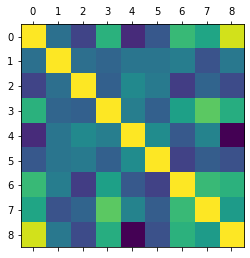

In [28]:
import matplotlib.pyplot as plt

plt.matshow(df_merged.corr())
plt.show()

In [29]:
df_merged.describe()

,pat_enc_csn_id_coded,num_unq_wrkstn,tpa_min,avg_task_switching,view_count,day_since_last_tpa,joint_tpa_count_within_6mo,TPA_ANY_EXPERIENCE,year
count,2.280000e+02,228.000000,228.000000,228.000000,228.000000,226.000000,215.000000,215.000000,228.000000
mean,1.310847e+11,1.784138,57.070175,36.628007,24.048070,11.902655,0.201853,0.780803,2013.916667
std,7.244018e+07,0.345325,40.872579,14.453806,18.886473,15.854037,0.141259,0.695684,1.795021
min,1.310115e+11,1.176471,1.000000,9.111111,3.391304,0.000000,0.003953,0.079051,2010.000000
25%,1.310220e+11,1.550000,31.000000,25.602941,9.922222,3.000000,0.097984,0.369396,2012.000000
50%,1.310545e+11,1.711982,48.500000,35.019481,18.262452,7.000000,0.169951,0.595402,2014.000000
75%,1.311656e+11,1.950595,67.500000,45.073478,31.294028,14.750000,0.266667,0.870844,2015.000000
max,1.312295e+11,4.266667,285.000000,88.150000,105.923077,104.000000,0.735294,5.772059,2017.000000


### Bivariate Coefficients

In [30]:
from sklearn.linear_model import LinearRegression 
from scipy.stats.stats import pearsonr 

metric_list = ['num_unq_wrkstn', 'avg_task_switching', 'view_count', 'day_since_last_tpa', 'joint_tpa_count_within_6mo', 'TPA_ANY_EXPERIENCE']
for metric in metric_list:
    X = np.nan_to_num(df_merged[metric].to_numpy().reshape((-1,1)))
    Y = np.nan_to_num(df_merged['tpa_min'].to_numpy().reshape((-1,1)))
    #reg = LinearRegression().fit(X, Y)
    X = sm.add_constant(X)
    mod = sm.OLS(Y,X)
    fii = mod.fit()
    print('*********', metric )
    #print('pearson correlation')
    #print(pearsonr(np.reshape(X,(-1,)), np.reshape((Y),(-1,))))
    print('bivariate coefficients')
    print(fii.conf_int(alpha=0.05, cols=None)[1])
    print(fii.params) 
    print((np.mean(X), np.median(X), np.std(X), np.min(X), np.max(X))) 
    print(fii.summary2().tables[1]['P>|t|'].x1)

********* num_unq_wrkstn
bivariate coefficients
[-20.02265662  10.98310361]
[65.13407926 -4.5197765 ]
(1.3920688683674802, 1.0882352941176472, 0.4616073167701089, 1.0, 4.2666666666666675)
0.566205762104966
********* avg_task_switching
bivariate coefficients
[-0.73846935 -0.00355775]
[70.65966235 -0.37101355]
(18.81400341699967, 5.055555555555556, 20.526491085220776, 1.0, 88.14999999999998)
0.04784104977468313
********* view_count
bivariate coefficients
[0.02264757 0.58437205]
[49.7713504   0.30350981]
(12.524034897796374, 2.1956521739130435, 17.617337192504234, 1.0, 105.92307692307692)
0.034301842447865105
********* day_since_last_tpa
bivariate coefficients
[-0.24361941  0.43308909]
[55.95247052  0.09473484]
(6.399122807017544, 1.0, 12.40113177923576, 0.0, 104.0)
0.5816858583615019
********* joint_tpa_count_within_6mo
bivariate coefficients
[-129.54114788  -59.91861905]
[ 75.10144221 -94.72988346]
(0.5951720096946185, 0.8676470588235294, 0.41754705116878427, 0.0, 1.0)
2.027115056088023

### Multivariate Coefficients

In [31]:
# Build contrasts
x_raw = df_merged[['gender','year','age_range','race','ethnicity']]
Y = df_merged['tpa_min']
df_dummies = pd.get_dummies(x_raw, prefix=['gender','year','age_range','race','ethnicity'], prefix_sep='.', 
                            columns=['gender','year','age_range','race','ethnicity'])
df_contrasts = df_dummies.drop(['gender.Female', 'year.2017', 'age_range.18-49', 'race.White', 'ethnicity.Non-Hispanic'], axis=1)
model_df = df_contrasts

array([[<AxesSubplot:title={'center':'joint_tpa_count_within_6mo'}>]],
      dtype=object)

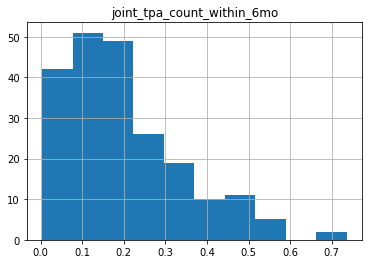

In [32]:
df_merged.hist(bins=10, column='joint_tpa_count_within_6mo')

In [33]:
df_merged[df_merged.joint_tpa_count_within_6mo > 1]

,pat_enc_csn_id_coded,num_unq_wrkstn,tpa_min,avg_task_switching,view_count,day_since_last_tpa,joint_tpa_count_within_6mo,TPA_ANY_EXPERIENCE,gender,ethnicity,race,age_range,year


In [34]:
metric_list = ['num_unq_wrkstn', 'avg_task_switching', 'view_count', 'day_since_last_tpa', 'joint_tpa_count_within_6mo', 'TPA_ANY_EXPERIENCE']
for metric in metric_list:
    #X = np.nan_to_num(df_merged[metric].to_numpy().reshape((-1,1)))
    #Y = np.nan_to_num(df_merged['tpa_min'].to_numpy().reshape((-1,1)))
    model_df[metric] = df_merged[metric]
    X = sm.add_constant(model_df)
    mod = sm.OLS(Y,X,missing='drop')
    results = mod.fit()
    print('*********', metric )
    print('multivariate coefficients')
    #print(results.params.loc[metric])
    print(results.summary())
    print(results.conf_int(alpha=0.05, cols=None).loc[metric])
    model_df = model_df.drop(metric,axis=1)

********* num_unq_wrkstn
multivariate coefficients
                            OLS Regression Results                            
Dep. Variable:                tpa_min   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.748
Date:                Mon, 22 Aug 2022   Prob (F-statistic):             0.0284
Time:                        15:10:39   Log-Likelihood:                -1151.2
No. Observations:                 228   AIC:                             2344.
Df Residuals:                     207   BIC:                             2416.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/ccrose/opt/anaconda3/lib/pyth

In [35]:
model_df['joint_tpa_count_within_6mo']=np.nan_to_num(df_merged[metric].to_numpy().reshape((-1,1)))
    #Y = np.nan_to_num(df_merged['tpa_min'].to_numpy().reshape((-1,1)))

In [36]:
model_df

,gender.Male,year.2010,year.2011,year.2012,year.2013,year.2014,year.2015,year.2016,age_range.50-59,age_range.60-69,age_range.70-79,age_range.80+,race.Asian,race.Black,race.Native American,race.Pacific Islander,race.Unknown,ethnicity.Hispanic/Latino,ethnicity.Unknown,joint_tpa_count_within_6mo
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
5,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
7,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.000000
8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
9,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000


In [37]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                tpa_min   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.743
Date:                Mon, 22 Aug 2022   Prob (F-statistic):             0.0322
Time:                        15:10:40   Log-Likelihood:                -1090.2
No. Observations:                 215   AIC:                             2220.
Df Residuals:                     195   BIC:                             2288.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [38]:
np.nan_to_num(df_merged['joint_tpa_count_within_6mo'].to_numpy().reshape((-1,1)))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.05555556],
       [0.05228758],
       [0.00584795],
       [0.11695906],
       [0.44664032],
       [0.06432749],
       [0.03384615],
       [0.02898551],
       [0.01960784],
       [0.05714286],
       [0.12333333],
       [0.03267974],
       [0.14102564],
       [0.08831909],
       [0.11428571],
       [0.07977208],
       [0.09475806],
       [0.04743083],
       [0.05555556],
       [0.11111111],
       [0.21666667],
       [0.08571429],
       [0.1991342 ],
       [0.16339869],
       [0.18571429],
       [0.18666667],
       [0.01960784],
       [0.06190476],
       [0.08172043],
       [0.1025641 ],
       [0.1005291 ],
       [0.04395604],
       [0.14705882],
       [0.07619048],
       [0.233

 ### Quartile Analysis of Team Variables

In [39]:
# Build contrasts

# Get raw data
x_raw = df_merged[['joint_tpa_count_within_6mo', 'TPA_ANY_EXPERIENCE']]
Y = df_merged['tpa_min']

# Convert to categories
x_raw['q_joint_tpa'] = pd.qcut(x_raw['joint_tpa_count_within_6mo'], 4, labels=["1", "2", "3", "4"])
x_raw['q_any_exp'] = pd.qcut(x_raw['TPA_ANY_EXPERIENCE'], 4, labels=["1", "2", "3", "4"])

# Remove the continuous vars
x_raw = x_raw.drop(['joint_tpa_count_within_6mo', 'TPA_ANY_EXPERIENCE'], axis=1)

# Convert to contrasts
df_dummies = pd.get_dummies(x_raw, prefix=['joint', 'any'], prefix_sep='.', 
                            columns=['q_joint_tpa','q_any_exp'])
df_contrasts = df_dummies.drop(['joint.1', 'any.1'], axis=1)
qmodel_df = df_contrasts

/var/folders/s7/_2909wnj7193pkfffbm3pjxw0000gp/T/ipykernel_12884/2904082869.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_raw['q_joint_tpa'] = pd.qcut(x_raw['joint_tpa_count_within_6mo'], 4, labels=["1", "2", "3", "4"])
/var/folders/s7/_2909wnj7193pkfffbm3pjxw0000gp/T/ipykernel_12884/2904082869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_raw['q_any_exp'] = pd.qcut(x_raw['TPA_ANY_EXPERIENCE'], 4, labels=["1", "2", "3", "4"])


In [40]:
metric_list = [['joint.2','joint.3','joint.4'],['any.2','any.3','any.4']]
for metric in metric_list:
    #X = np.nan_to_num(df_merged[metric].to_numpy().reshape((-1,1)))
    X = qmodel_df[metric]
    Y = np.nan_to_num(df_merged['tpa_min'].to_numpy().reshape((-1,1)))
    X = sm.add_constant(X)
    mod = sm.OLS(Y,X)
    results = mod.fit()
    print('*********', metric )
    print('quartiles coefficients')
    print(results.params.loc[metric]) 
    print(results.conf_int(alpha=0.05, cols=None).loc[metric])

********* ['joint.2', 'joint.3', 'joint.4']
quartiles coefficients
joint.2   -13.060807
joint.3   -21.001408
joint.4   -38.690437
dtype: float64
                 0          1
joint.2 -26.950931   0.829317
joint.3 -34.963902  -7.038914
joint.4 -52.580561 -24.800313
********* ['any.2', 'any.3', 'any.4']
quartiles coefficients
any.2   -0.114704
any.3   -5.796395
any.4   -6.503593
dtype: float64
               0          1
any.2 -14.900959  14.671550
any.3 -20.659689   9.066899
any.4 -21.289848   8.282662


/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/ccrose/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
print(x_raw)

    q_joint_tpa q_any_exp
0           NaN       NaN
1           NaN       NaN
2           NaN       NaN
3           NaN       NaN
4           NaN       NaN
5           NaN       NaN
6           NaN       NaN
7           NaN       NaN
8           NaN       NaN
9           NaN       NaN
10          NaN       NaN
11          NaN       NaN
12          NaN       NaN
13            1         1
14            1         2
15            1         2
16            2         3
17            4         3
18            1         2
19            1         1
20            1         1
21            1         1
22            1         1
23            2         1
24            1         1
25            2         2
26            1         2
27            2         2
28            1         1
29            1         1
30            1         1
31            1         2
32            2         4
33            3         3
34            1         2
35            3         3
36            2         3
37          

In [42]:
print(fii.params)
print(results.params.loc[metric]) #np.mean(X), np.median(X), np.std(X), np.min(X), np.max(X), 
print(results.conf_int(alpha=0.05, cols=None).loc[metric])

[62.19267791 -6.95723897]
any.2   -0.114704
any.3   -5.796395
any.4   -6.503593
dtype: float64
               0          1
any.2 -14.900959  14.671550
any.3 -20.659689   9.066899
any.4 -21.289848   8.282662


In [43]:
model_df

,gender.Male,year.2010,year.2011,year.2012,year.2013,year.2014,year.2015,year.2016,age_range.50-59,age_range.60-69,age_range.70-79,age_range.80+,race.Asian,race.Black,race.Native American,race.Pacific Islander,race.Unknown,ethnicity.Hispanic/Latino,ethnicity.Unknown,joint_tpa_count_within_6mo
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
5,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
7,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.000000
8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
9,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000
